In [375]:
import pandas as pd
import pandapower as pp
import pandapower.networks as ppnets
import pandapower.plotting as plt
import matplotlib.pyplot as mplt


In [376]:
# 엑셀 읽어오는 함수
def read(file_path: str, sheet_name: str):
    df = pd.read_excel(file_path, 
                       sheet_name=sheet_name, 
                       engine='openpyxl')
    return df

In [377]:
file_path = 'ac_case25.xlsx'

BUS = read(file_path, 'bus')
GEN = read(file_path, 'generator')
TR = read(file_path, 'transformer')
LINE = read(file_path, 'branch')
BASE = read(file_path, 'param')

In [378]:
# 계통 생성
net = pp.create.create_empty_network(
    name='case25',
    f_hz=60.0, 
    sn_mva=100, 
    add_stdtypes=True
    )

In [379]:
# 발전기 정보 수집, 전력은 더하기, voltage set point는 동일하기 때문에 첫번쨰 값으로 통일일
G = GEN.groupby('Bus', as_index=False).agg({
    'PG (MW)': 'sum',
    'QG (MVAR)': 'sum',
    'QMAX (MVAR)': 'sum',
    'QMIN (MVAR)': 'sum',
    'Voltage setpoint (pu)': 'first'
})

print(G)

    Bus  PG (MW)  QG (MVAR)  QMAX (MVAR)  QMIN (MVAR)  Voltage setpoint (pu)
0     1    172.0        0.0           80          -50                  1.035
1     2    172.0        0.0           80          -50                  1.035
2     7    240.0        0.0          180            0                  1.025
3    13    285.3        0.0          240            0                  1.020
4    14      0.0       35.3          200          -50                  0.980
5    15    215.0        0.0          110          -50                  1.014
6    16    155.0        0.0           80          -50                  1.017
7    18    400.0        0.0          200          -50                  1.050
8    21    400.0        0.0          200          -50                  1.050
9    22    300.0        0.0           96          -60                  1.050
10   23    660.0        0.0          310         -125                  1.050


In [380]:
B = BUS.copy()

B.rename(columns={
    'Pload (MW)': 'P (MW)',
    'Qload (MVAR)': 'Q (MVAR)',
}, inplace=True)

# 부하의 경우 (-)
B.loc[:,'P (MW)'] = B.loc[:,'P (MW)']*(-1) 
B.loc[:,'Q (MVAR)'] = B.loc[:,'Q (MVAR)']*(-1) 

print(B)

    Bus   Type  P (MW)  Q (MVAR)  area  Vm (pu)  Va (degree)  maxVm  minVm
0     1     PV -108.00    -22.00     1        1            0   1.05   0.95
1     2     PV  -97.00    -20.00     1        1            0   1.05   0.95
2     3     PQ -207.00    -42.55     1        1            0   1.05   0.95
3     4     PQ  -74.00    -15.00     1        1            0   1.05   0.95
4     5     PQ  -71.00    -14.00     1        1            0   1.05   0.95
5     6     PQ -136.00    -28.00     2        1            0   1.05   0.95
6     7     PV -125.00    -25.00     2        1            0   1.05   0.95
7     8     PQ -136.80    -28.00     2        1            0   1.05   0.95
8     9     PQ -175.00    -36.00     1        1            0   1.05   0.95
9    10     PQ -156.00    -32.00     2        1            0   1.05   0.95
10   11     PQ   -0.00     -0.00     3        1            0   1.05   0.95
11   12     PQ   -0.00     -0.00     3        1            0   1.05   0.95
12   13  Swing -265.00   

In [381]:
for i in range(len(G)):
    B.loc[G.loc[i,'Bus']-1,'P (MW)'] += G.loc[i,'PG (MW)']

B['Vm (pu)'] = B['Vm (pu)'].astype(float)

for i in range(len(G)):
    B.loc[G.loc[i,'Bus']-1,'Vm (pu)'] = G.loc[i,'Voltage setpoint (pu)']

print(B)

    Bus   Type  P (MW)  Q (MVAR)  area  Vm (pu)  Va (degree)  maxVm  minVm
0     1     PV   64.00    -22.00     1    1.035            0   1.05   0.95
1     2     PV   75.00    -20.00     1    1.035            0   1.05   0.95
2     3     PQ -207.00    -42.55     1    1.000            0   1.05   0.95
3     4     PQ  -74.00    -15.00     1    1.000            0   1.05   0.95
4     5     PQ  -71.00    -14.00     1    1.000            0   1.05   0.95
5     6     PQ -136.00    -28.00     2    1.000            0   1.05   0.95
6     7     PV  115.00    -25.00     2    1.025            0   1.05   0.95
7     8     PQ -136.80    -28.00     2    1.000            0   1.05   0.95
8     9     PQ -175.00    -36.00     1    1.000            0   1.05   0.95
9    10     PQ -156.00    -32.00     2    1.000            0   1.05   0.95
10   11     PQ   -0.00     -0.00     3    1.000            0   1.05   0.95
11   12     PQ   -0.00     -0.00     3    1.000            0   1.05   0.95
12   13  Swing   20.30   

In [382]:
# pandapower의 bus를 만드는 함수, 실제 전압값은 모르므로 1.0Kv
def mkbus(net, 
          name,
          index, 
          geodata, 
          type_, 
          zone, 
          in_service,
          max_vm_pu, 
          min_vm_pu, 
          coords,
          vn_kv=1.0):
    bus = pp.create_bus(
        net,
        vn_kv=vn_kv,
        name=name,
        index=index,
        geodata=geodata,
        type=type_,
        zone=zone,
        in_service=in_service,
        max_vm_pu=max_vm_pu,
        min_vm_pu=min_vm_pu,
        coords=coords
    )
    return bus

In [383]:
for i in range(len(B)):
    mkbus(net,
          i+1,
          i+1,
          None,
          'b',
          None,
          True,
          B.loc[i,'maxVm'],
          B.loc[i,'minVm'],
          None,
          B.loc[i,'Vm (pu)'])

In [384]:
net.bus

,name,vn_kv,type,zone,in_service,geo,min_vm_pu,max_vm_pu
1,1,1.035,b,None,True,None,0.95,1.05
2,2,1.035,b,None,True,None,0.95,1.05
3,3,1.000,b,None,True,None,0.95,1.05
4,4,1.000,b,None,True,None,0.95,1.05
5,5,1.000,b,None,True,None,0.95,1.05
6,6,1.000,b,None,True,None,0.95,1.05
7,7,1.025,b,None,True,None,0.95,1.05
8,8,1.000,b,None,True,None,0.95,1.05
9,9,1.000,b,None,True,None,0.95,1.05
10,10,1.000,b,None,True,None,0.95,1.05


In [385]:
# 발전기들의 정보를 만드는 함수수
def mkgen(
    net,
    bus,
    index,
    p_mw, 
    max_q_mvar, 
    min_q_mvar,
    max_vm_pu, 
    min_vm_pu,
    vm_pu=1.0, 
    slack=False,
):
    pp.create.create_gen(
        net,
        bus=bus,
        index=index,
        p_mw=p_mw,
        vm_pu=vm_pu,
        max_q_mvar=max_q_mvar, 
        min_q_mvar=min_q_mvar, 
        min_vm_pu=min_vm_pu, 
        max_vm_pu=max_vm_pu, 
        slack=slack, 
    )


In [386]:
for i in range(len(G)):
    mkgen(
        net,
        G.loc[i, 'Bus'],
        G.loc[i, 'Bus'],
        G.loc[i, 'PG (MW)'],
        G.loc[i, 'QMAX (MVAR)'],
        G.loc[i, 'QMIN (MVAR)'],
        B.loc[G.loc[i, 'Bus'] + 1, 'maxVm'],
        B.loc[G.loc[i, 'Bus'] + 1, 'minVm'],
        G.loc[i, 'Voltage setpoint (pu)'],
        B.loc[G.loc[i, 'Bus'] - 1, 'Type'] == 'Swing'
    )


In [387]:
net.gen

,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type,max_vm_pu,min_vm_pu
1,None,1,172.0,1.035,NaN,-50.0,80.0,1.0,False,True,0.0,None,1.05,0.95
2,None,2,172.0,1.035,NaN,-50.0,80.0,1.0,False,True,0.0,None,1.05,0.95
7,None,7,240.0,1.025,NaN,0.0,180.0,1.0,False,True,0.0,None,1.05,0.95
13,None,13,285.3,1.020,NaN,0.0,240.0,1.0,True,True,0.0,None,1.05,0.95
14,None,14,0.0,0.980,NaN,-50.0,200.0,1.0,False,True,0.0,None,1.05,0.95
15,None,15,215.0,1.014,NaN,-50.0,110.0,1.0,False,True,0.0,None,1.05,0.95
16,None,16,155.0,1.017,NaN,-50.0,80.0,1.0,False,True,0.0,None,1.05,0.95
18,None,18,400.0,1.050,NaN,-50.0,200.0,1.0,False,True,0.0,None,1.05,0.95
21,None,21,400.0,1.050,NaN,-50.0,200.0,1.0,False,True,0.0,None,1.05,0.95
22,None,22,300.0,1.050,NaN,-60.0,96.0,1.0,False,True,0.0,None,1.05,0.95


In [388]:
# 무효전력생성기의 정보를 만드는 함수수
def mkshunt(net, 
            bus,
            index,
            q_mvar,
            p_mw = 0):
    pp.create_shunt(net, 
                bus=bus, 
                index=index,
                q_mvar=q_mvar, 
                p_mw=p_mw)

In [389]:
mkshunt(net,14,14,35.3,)

In [390]:
net.shunt

,bus,name,q_mvar,p_mw,vn_kv,step,max_step,id_characteristic_table,step_dependency_table,in_service
14,14,None,35.3,0.0,0.98,1,1,<NA>,False,True


In [391]:
# 부하 생성성
def mkload(net,
           bus,
           index,
           p_mw,
           q_mvar,
            ):

    pp.create_load(net, 
                   bus=bus, 
                   index=index,
                   p_mw=p_mw, 
                   q_mvar=q_mvar)
    

In [392]:
for i in range(len(BUS)):
    mkload(
        net,
        BUS.loc[i, 'Bus'],
        BUS.loc[i, 'Bus'],
        BUS.loc[i, 'Pload (MW)'],
        BUS.loc[i, 'Qload (MVAR)'],
    )

In [393]:
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
1,None,1,108.00,22.00,0.0,0.0,NaN,1.0,True,wye
2,None,2,97.00,20.00,0.0,0.0,NaN,1.0,True,wye
3,None,3,207.00,42.55,0.0,0.0,NaN,1.0,True,wye
4,None,4,74.00,15.00,0.0,0.0,NaN,1.0,True,wye
5,None,5,71.00,14.00,0.0,0.0,NaN,1.0,True,wye
6,None,6,136.00,28.00,0.0,0.0,NaN,1.0,True,wye
7,None,7,125.00,25.00,0.0,0.0,NaN,1.0,True,wye
8,None,8,136.80,28.00,0.0,0.0,NaN,1.0,True,wye
9,None,9,175.00,36.00,0.0,0.0,NaN,1.0,True,wye
10,None,10,156.00,32.00,0.0,0.0,NaN,1.0,True,wye


In [394]:
# 임피던스 생성하는 함수, 여기서는 r x b 값을 사용하기위해 이것을 사용함
# ohm/km의 경우 create_line 사용하기용하기
def mkimp(
        net,
        from_bus,
        to_bus,
        rft_pu,
        xft_pu,
        bf_pu,
        bt_pu,
        sn_mva = 100
        ):
    pp.create_impedance(net, 
                        from_bus=from_bus, 
                        to_bus=to_bus, 
                        rft_pu=rft_pu, 
                        xft_pu=xft_pu,
                        bf_pu=bf_pu,
                        bt_pu=bt_pu, 
                        sn_mva=sn_mva, )
    

In [395]:
# 변압기와 선로 데이터 분리를 위한 인덱스 저장
# TR 데이터 프레임에 정보가 있는 경우의 From, To를 저장
mask = LINE.set_index(['From', 'To']).index.isin(TR.set_index(['From', 'To']).index)

# TRad에는 조건을 만족하는 행 저장
TRad = LINE[mask].copy()

# LINE은 조건을 만족하지 않는 나머지 행만 남김
LINE = LINE[~mask].reset_index(drop=True)
TRad = TRad.reset_index(drop=True)

# 확인용 출력
print("LINE:")
print(LINE)
print("\nTRad:")
print(TRad)

LINE:
    From  To   R (pu)    X (pu)  B (pu)
0      1   2  0.00260  0.013900  0.4611
1      1   3  0.05460  0.211200  0.0572
2      1   5  0.02180  0.084500  0.0229
3      2   4  0.03280  0.126700  0.0343
4      2   6  0.04970  0.192000  0.0520
5      3   9  0.03080  0.119000  0.0322
6      4   9  0.02680  0.103700  0.0281
7      5  10  0.02280  0.088300  0.0239
8      6  10  0.01390  0.060500  2.4590
9      7   8  0.01590  0.061400  0.0166
10     8   9  0.04270  0.165100  0.0447
11     8  10  0.04270  0.165100  0.0447
12    11  13  0.00610  0.047600  0.0999
13    11  14  0.00540  0.041800  0.0879
14    12  13  0.00610  0.047600  0.0999
15    12  23  0.01240  0.096600  0.2030
16    13  23  0.01110  0.086500  0.1818
17    14  16  0.00500  0.038900  0.0818
18    15  16  0.00220  0.017300  0.0364
19    15  21  0.00630  0.049000  0.1030
20    15  21  0.00630  0.049000  0.1030
21    15  24  0.00670  0.051900  0.1091
22    16  17  0.00330  0.025900  0.0545
23    16  19  0.00300  0.023100  0

In [396]:
for i in range(len(LINE)):
    mkimp(
        net,
        LINE.loc[i, 'From'],
        LINE.loc[i, 'To'],
        LINE.loc[i, 'R (pu)'],
        LINE.loc[i, 'X (pu)'],
        LINE.loc[i, 'B (pu)'] / 2,
        LINE.loc[i, 'B (pu)'] / 2,
        100
    )


In [397]:
net.impedance

,name,from_bus,to_bus,rft_pu,xft_pu,rtf_pu,xtf_pu,gf_pu,bf_pu,gt_pu,bt_pu,sn_mva,in_service
0,None,1,2,0.00260,0.013900,0.00260,0.013900,0.0,0.23055,0.0,0.23055,100.0,True
1,None,1,3,0.05460,0.211200,0.05460,0.211200,0.0,0.02860,0.0,0.02860,100.0,True
2,None,1,5,0.02180,0.084500,0.02180,0.084500,0.0,0.01145,0.0,0.01145,100.0,True
3,None,2,4,0.03280,0.126700,0.03280,0.126700,0.0,0.01715,0.0,0.01715,100.0,True
4,None,2,6,0.04970,0.192000,0.04970,0.192000,0.0,0.02600,0.0,0.02600,100.0,True
5,None,3,9,0.03080,0.119000,0.03080,0.119000,0.0,0.01610,0.0,0.01610,100.0,True
6,None,4,9,0.02680,0.103700,0.02680,0.103700,0.0,0.01405,0.0,0.01405,100.0,True
7,None,5,10,0.02280,0.088300,0.02280,0.088300,0.0,0.01195,0.0,0.01195,100.0,True
8,None,6,10,0.01390,0.060500,0.01390,0.060500,0.0,1.22950,0.0,1.22950,100.0,True
9,None,7,8,0.01590,0.061400,0.01590,0.061400,0.0,0.00830,0.0,0.00830,100.0,True


In [398]:
# 변압기 정보를 생성하는 함수
# vkr_percent (float) - real part of relative short-circuit voltage
# vk_percent (float) - relative short-circuit voltage

# 단락시험은 정격전류에서 이뤄짐 따라서 전류는 1.0pu 이때 전압은?
# 상대 단락 전압은 Vshort/Vrated * 100 
# Vshort pu = Z pu* I pu = Z pu

def mktrafo(
    net,
    hv_bus,
    lv_bus,
    vn_hv_kv,
    vn_lv_kv,
    vk_percent,
    vkr_percent,
    pfe_kw,
    i0_percent,
    sn_mva=100,
):
    pp.create_transformer_from_parameters(
        net,
        hv_bus=hv_bus,
        lv_bus=lv_bus,
        sn_mva=sn_mva,
        vn_hv_kv=vn_hv_kv,
        vn_lv_kv=vn_lv_kv,
        vkr_percent=vkr_percent,
        vk_percent=vk_percent,
        pfe_kw=pfe_kw,
        i0_percent=i0_percent
    )


In [399]:
Zpu = pd.DataFrame()
Zpu['From'] = TRad['From']
Zpu['To'] = TRad['To']
Zpu['Zpu'] = TRad['R (pu)'] + 1j * TRad['X (pu)']


for i in range(len(Zpu)):
    Zpu['vk_percent'] = abs(Zpu.loc[i,'Zpu'])*100
    Zpu['vkr_percent'] = Zpu.loc[i,'Zpu'].real*100

print(Zpu)

   From  To             Zpu  vk_percent  vkr_percent
0     3  24  0.0023+0.0839j    8.393152         0.23
1     9  11  0.0023+0.0839j    8.393152         0.23
2     9  12  0.0023+0.0839j    8.393152         0.23
3    10  11  0.0023+0.0839j    8.393152         0.23
4    10  12  0.0023+0.0839j    8.393152         0.23


In [400]:
for i in range(len(TR)):
    mktrafo(
        net,
        TR.loc[i,'To'],
        TR.loc[i,'From'],
        1,
        1 / TR.loc[i,'Tap'],
        Zpu.loc[i,'vk_percent'],
        Zpu.loc[i,'vkr_percent'],
        0,
        0,
        100,
    )

In [401]:
net.trafo

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,...,tap_max,tap_step_percent,tap_step_degree,tap_pos,tap_changer_type,id_characteristic_table,tap_dependency_table,parallel,df,in_service
0,None,None,24,3,100.0,1.0,0.970874,8.393152,0.23,0.0,...,NaN,NaN,NaN,NaN,NaN,<NA>,False,1,1.0,True
1,None,None,11,9,100.0,1.0,0.970874,8.393152,0.23,0.0,...,NaN,NaN,NaN,NaN,NaN,<NA>,False,1,1.0,True
2,None,None,12,9,100.0,1.0,0.970874,8.393152,0.23,0.0,...,NaN,NaN,NaN,NaN,NaN,<NA>,False,1,1.0,True
3,None,None,11,10,100.0,1.0,0.980392,8.393152,0.23,0.0,...,NaN,NaN,NaN,NaN,NaN,<NA>,False,1,1.0,True
4,None,None,12,10,100.0,1.0,0.980392,8.393152,0.23,0.0,...,NaN,NaN,NaN,NaN,NaN,<NA>,False,1,1.0,True


In [402]:
pp.runpp(net,numba=False)

In [403]:
Ybus = net._ppc["internal"]["Ybus"] 

In [404]:
Ybus_dense = Ybus.todense()
print(Ybus_dense)

[[ 17.01191877 -84.77385682j -13.00195029 +69.51042656j
   -1.14738183  +4.43822421j   0.          +0.j
   -2.86258665 +11.09580605j   0.          +0.j
    0.          +0.j           0.          +0.j
    0.          +0.j           0.          +0.j
    0.          +0.j           0.          +0.j
    0.          +0.j           0.          +0.j
    0.          +0.j           0.          +0.j
    0.          +0.j           0.          +0.j
    0.          +0.j           0.          +0.j
    0.          +0.j           0.          +0.j
    0.          +0.j           0.          +0.j
    0.          +0.j        ]
 [-13.00195029 +69.51042656j  16.18039669 -81.51491761j
    0.          +0.j          -1.91491138  +7.39692902j
    0.          +0.j          -1.26353502  +4.88126203j
    0.          +0.j           0.          +0.j
    0.          +0.j           0.          +0.j
    0.          +0.j           0.          +0.j
    0.          +0.j           0.          +0.j
    0.          +0.j      

In [405]:
# 부하가 (+)
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
1,1.035000,-6.722936,-64.000000,-11.802248
2,1.035000,-6.775811,-75.000000,13.576014
3,0.949912,-6.434613,207.000000,42.550000
4,0.970924,-8.908203,74.000000,15.000000
5,1.023433,-8.944611,71.000000,14.000000
6,1.070794,-11.607262,136.000000,28.000000
7,1.025000,-4.719629,-115.000000,-25.029790
8,0.993765,-8.462380,136.800000,28.000000
9,0.968497,-6.714068,175.000000,36.000000
10,1.038066,-8.019630,156.000000,32.000000


In [406]:
net.res_bus.round(decimals=4)

,vm_pu,va_degree,p_mw,q_mvar
1,1.0350,-6.7229,-64.0000,-11.8022
2,1.0350,-6.7758,-75.0000,13.5760
3,0.9499,-6.4346,207.0000,42.5500
4,0.9709,-8.9082,74.0000,15.0000
5,1.0234,-8.9446,71.0000,14.0000
6,1.0708,-11.6073,136.0000,28.0000
7,1.0250,-4.7196,-115.0000,-25.0298
8,0.9938,-8.4624,136.8000,28.0000
9,0.9685,-6.7141,175.0000,36.0000
10,1.0381,-8.0196,156.0000,32.0000


In [407]:
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent


In [408]:
profiles = 0


In [409]:
profiles = pd.read_csv('testload25.csv',header=None)
profiles.columns = range(1, profiles.shape[1] + 1)
profiles = profiles * 100

In [410]:
print(profiles)

            1          2           3          4          5           6   \
0    43.200000  38.800000   82.800000  29.600000  28.400000   54.400000   
1    48.600000  43.650000   93.150000  33.300000  31.950000   61.200000   
2    54.000000  48.500000  103.500000  37.000000  35.500000   68.000000   
3    59.400000  53.350000  113.850000  40.700000  39.050000   74.800000   
4    64.800000  58.200000  124.200000  44.400000  42.600000   81.600000   
5    70.200000  63.050000  134.550000  48.100000  46.150000   88.400000   
6    75.600000  67.900000  144.900000  51.800000  49.700000   95.200000   
7    81.000000  72.750000  155.250000  55.500000  53.250000  102.000000   
8    86.400000  77.600000  165.600000  59.200000  56.800000  108.800000   
9    91.800000  82.450000  175.950000  62.900000  60.350000  115.600000   
10   97.200000  87.300000  186.300000  66.600000  63.900000  122.400000   
11  102.600000  92.150000  196.650000  70.300000  67.450000  129.200000   
12  108.000000  97.000000

In [411]:
from pandapower.timeseries import DFData
ds = DFData(profiles)

In [412]:
print(ds.df)

            1          2           3          4          5           6   \
0    43.200000  38.800000   82.800000  29.600000  28.400000   54.400000   
1    48.600000  43.650000   93.150000  33.300000  31.950000   61.200000   
2    54.000000  48.500000  103.500000  37.000000  35.500000   68.000000   
3    59.400000  53.350000  113.850000  40.700000  39.050000   74.800000   
4    64.800000  58.200000  124.200000  44.400000  42.600000   81.600000   
5    70.200000  63.050000  134.550000  48.100000  46.150000   88.400000   
6    75.600000  67.900000  144.900000  51.800000  49.700000   95.200000   
7    81.000000  72.750000  155.250000  55.500000  53.250000  102.000000   
8    86.400000  77.600000  165.600000  59.200000  56.800000  108.800000   
9    91.800000  82.450000  175.950000  62.900000  60.350000  115.600000   
10   97.200000  87.300000  186.300000  66.600000  63.900000  122.400000   
11  102.600000  92.150000  196.650000  70.300000  67.450000  129.200000   
12  108.000000  97.000000

In [413]:
print(profiles.index)
print(profiles.columns)
print(ds.df.index)

RangeIndex(start=0, stop=24, step=1)
RangeIndex(start=1, stop=26, step=1)
RangeIndex(start=0, stop=24, step=1)


In [414]:
from pandapower.control import ConstControl

for i in range(1,26):
    ConstControl(net, 
                 element='load', 
                 variable='p_mw', 
                 element_index=[i], 
                 data_source=ds, 
                 profile_name=i)

In [415]:
print(ConstControl)

<class 'pandapower.control.controller.const_control.ConstControl'>


In [416]:
# def create_controllers(net, ds):
#     ConstControl(net, element='load', variable='p_mw', element_index=[0],
#                  data_source=ds, profile_name=i)

In [417]:
def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, 
                      time_steps, 
                      output_path=output_dir, 
                      output_file_type=".xlsx", 
                      log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_line', 'i_ka')
    return ow

In [418]:
from pandapower.timeseries import run_timeseries

def timeseries_example(output_dir):
    # 1. create test net

    # 2. create (random) data source
    n_timesteps = 24
    # 3. create controllers (to control P values of the load and the sgen)
    # create_controllers(net, ds)

    # time steps to be calculated. Could also be a list with non-consecutive time steps
    time_steps = range(0, n_timesteps)

    # 4. the output writer with the desired results to be stored to files.
    ow = create_output_writer(net, 
                              time_steps, 
                              output_dir=output_dir)

    # 5. the main time series function
    run_timeseries(net, time_steps)
    print(net.res_line.loading_percent)


In [419]:
from pandapower.timeseries import OutputWriter
import tempfile
import os

output_dir = os.path.join(tempfile.gettempdir(), "time_series_example")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
timeseries_example(output_dir)

Results can be found in your local temp folder: C:\Users\User\AppData\Local\Temp\time_series_example




  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [00:00<00:00, 92.61it/s] 


Series([], Name: loading_percent, dtype: float64)


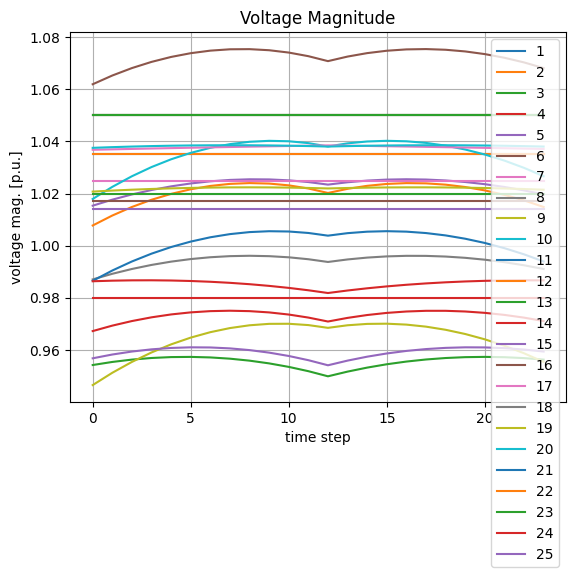

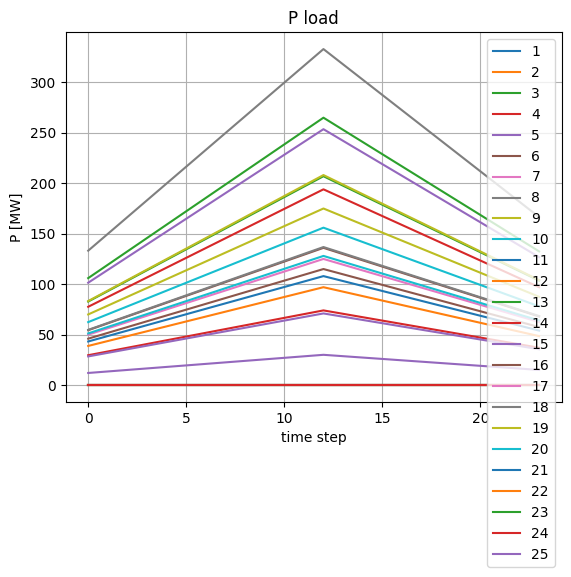

In [422]:
import matplotlib.pyplot as plt
%matplotlib inline  

# voltage results
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

# # line loading results
# ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
# line_loading = pd.read_excel(ll_file, index_col=0)
# line_loading.plot(label="line_loading")
# plt.xlabel("time step")
# plt.ylabel("line loading [%]")
# plt.title("Line Loading")
# plt.grid()
# plt.show()

# load results
load_file = os.path.join(output_dir, "res_load", "p_mw.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="load")
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.title("P load")
plt.grid()
plt.show()

In [421]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
1,1.035000,19.627313,-118.000000,-2.655225
2,1.035000,19.543541,-123.500000,20.264009
3,0.956316,19.751241,103.500000,42.550000
4,0.971102,15.868530,37.000000,15.000000
5,1.019664,15.061568,35.500000,14.000000
6,1.068129,11.383920,68.000000,28.000000
7,1.025000,23.739357,-177.500000,-18.804997
8,0.991074,17.758016,68.400000,28.000000
9,0.955427,13.136500,87.500000,36.000000
10,1.026642,11.826249,78.000000,32.000000


100%|██████████| 24/24 [00:12<00:00, 135.03it/s]